In [3]:
import numpy as np
import yt
import ytree
import math
import sys
import matplotlib.pyplot as plt
from matplotlib import cm
cmap = plt.get_cmap("gist_rainbow")

# Trying to find MM and LW in z-15 data

In [53]:
ds  = yt.load('rockstar_halos-z15/halos_RD0002.0.bin')
lwpos0 = ds.arr([14.36468, 15.49873, 15.03029], 'Mpccm/h')
lwmass = ds.quan(2.841e7, 'Msun/h')
mmpos0 = ds.arr([13.75719, 13.50339, 13.21519], 'Mpccm/h')
mmmass = ds.quan(3.909e7, 'Msun/h')

yt : [INFO     ] 2021-12-02 16:20:55,760 Parameters: current_time              = 8776710304200322.0 s
yt : [INFO     ] 2021-12-02 16:20:55,760 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2021-12-02 16:20:55,761 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2021-12-02 16:20:55,762 Parameters: domain_right_edge         = [28.39999962 28.39999962 28.39999962]
yt : [INFO     ] 2021-12-02 16:20:55,762 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2021-12-02 16:20:55,763 Parameters: current_redshift          = 15.0
yt : [INFO     ] 2021-12-02 16:20:55,763 Parameters: omega_lambda              = 0.734000027179718
yt : [INFO     ] 2021-12-02 16:20:55,763 Parameters: omega_matter              = 0.26600000262260437
yt : [INFO     ] 2021-12-02 16:20:55,764 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2021-12-02 16:20:55,765 Parameters: hubble_constant           = 0.7099999785423279


In [57]:
delta = 178.0
search = 3.0  # in units of rvir0
msearch = 0.3
p = ds.critical_density.to('Msun/Mpc**3')

halos = ds.all_data()
candpos = {}
allrvir = {}
# Professor Wise's code
for name, pos0, mass0 in zip(['LW', 'MM'], [lwpos0, mmpos0], [lwmass, mmmass]):
    candpos[name] = []
    dr = halos['particle_position'] - pos0
    r = (dr**2).sum(1)**0.5
    rvir0 = (mass0 / (4*np.pi/3 * delta*p))**(1.0/3)
    rvir = (halos['particle_mass'] / (4*np.pi/3 * delta*p))**(1.0/3)

    allrvir[name] = rvir0.to('kpc').v
    logdm = np.log10(halos['particle_mass'] / mass0)
    close = np.where((r < search*rvir0) & (np.abs(logdm) < msearch))[0]
    for c in close:
        print('[%s / %d] M=%.2g Msun (dlogM=%.2f) dr=%.2f kpc (rvir0=%.2f kpc)' % \
              (name, c, halos['particle_mass'][c].to('Msun'),
               logdm[c],
               r[c].to('kpc'), rvir0.to('kpc')))
        print('\t Halo position = %s' % (halos['particle_position'][c].to('Mpccm/h')))
        candpos[name].append([c, halos['particle_position'][c].to('Mpccm/h').v,
                              rvir[c].to('kpc').v])
    print('')

[LW / 114300] M=3.6e+07 Msun (dlogM=-0.04) dr=0.46 kpc (rvir0=0.71 kpc)
	 Halo position = [14.36803341 15.49479675 15.03044319] Mpccm/h

[MM / 129188] M=8.5e+07 Msun (dlogM=0.19) dr=1.44 kpc (rvir0=0.79 kpc)
	 Halo position = [13.7586298 13.5069313 13.2310915] Mpccm/h



# These are the best MM and LW candidates, found in the .bin outputs for the z-15 data. Let's try to find them in the out.list file

In [2]:
out_z15 = ytree.load('rockstar_halos-z15/out_0.list')
print(out_z15.field_list)

Additional features and improved performance (usually) by saving this arbor with "save_arbor" and reloading:
	>>> a = ytree.load("rockstar_halos-z15/out_0.list")
	>>> fn = a.save_arbor()
	>>> a = ytree.load(fn)
['ID', 'DescID', 'Mvir', 'Vmax', 'Vrms', 'Rvir', 'Rs', 'Np', 'X', 'Y', 'Z', 'VX', 'VY', 'VZ', 'JX', 'JY', 'JZ', 'Spin', 'rs_klypin', 'Mvir_all', 'M200b', 'M200c', 'M500c', 'M2500c', 'Xoff', 'Voff', 'spin_bullock', 'b_to_a', 'c_to_a', 'A[x]', 'A[y]', 'A[z]', 'b_to_a(500c)', 'c_to_a(500c)', 'A[x](500c)', 'A[y](500c)', 'A[z](500c)', 'T/|U|', 'M_pe_Behroozi', 'M_pe_Diemer', 'Type', 'SM', 'Gas', 'BH_Mass', 'scale_factor', 'uid', 'desc_uid']


In [3]:
m = out_z15["Mvir_all"]

Reading root fields: 100%|███████████████████████████████████████████████████| 162490/162490 [00:16<00:00, 9927.99it/s]


In [3]:
def find_halos_in_out_list(data, red, x,y,z, error):
    r,x,y,z,e = str(red), str(x),str(y),str(z), str(error)
    halo_list = list(data.select_halos('np.logical_and(abs(tree["tree","position_x"].to("Mpc/h").v-'+x+')<'+e+',np.logical_and(abs(tree["tree","position_y"].to("Mpc/h").v-'+y+')<'+e+',abs(tree["tree","position_z"].to("Mpc/h").v-'+z+')<'+e+' ))'))
    return halo_list

def print_halo_cands(halo_list):
    for h in halo_list: print (h, " ", h['position'].to('Mpc/h'), " ", h['mass'].to('Msun'), " ", h['Mvir_all'].to('Msun') , " ", h['ID'], "  ", h['DescID'] )

In [4]:
LW_id = 114300
LWm=3.6e+07 
LWp=[14.36803341, 15.49479675,15.03044319]
MM_id = 129188
MMm=8.5e+07 
MMp=[13.7586298, 13.5069313, 13.2310915]

In [5]:
MM_cands = find_halos_in_out_list(out_z15, 15,MMp[0], MMp[1], MMp[2], 0.01)

Selecting halos (found 9): 100%|█████████████████████████████████████████████| 162490/162490 [01:59<00:00, 1363.72it/s]


In [77]:
LW_cands = find_halos_in_out_list(out_z15, 15,LWp[0], LWp[1], LWp[2], 0.01)






Selecting halos (0 found):   0%|                                                            | 0/162490 [00:00<?, ?it/s]




Selecting halos (0 found):   0%|                                                | 333/162490 [00:00<00:49, 3305.83it/s]




Selecting halos (0 found):   0%|▏                                               | 658/162490 [00:00<00:49, 3281.62it/s]




Selecting halos (0 found):   1%|▎                                              | 1019/162490 [00:00<00:47, 3366.79it/s]




Selecting halos (0 found):   1%|▍                                              | 1370/162490 [00:00<00:47, 3401.27it/s]




Selecting halos (0 found):   1%|▍                                              | 1726/162490 [00:00<00:46, 3440.06it/s]




Selecting halos (0 found):   1%|▌                                              | 2076/162490 [00:00<00:46, 3450.37it/s]




Selecting halos (0 found):   1%|▋                                              | 2437/162490 [00:00<00:45, 3489.33it/s]




Sel

Selecting halos (0 found):  26%|████████████                                  | 42749/162490 [00:11<00:32, 3674.13it/s]




Selecting halos (0 found):  27%|████████████▏                                 | 43119/162490 [00:11<00:32, 3673.84it/s]




Selecting halos (0 found):  27%|████████████▎                                 | 43508/162490 [00:11<00:31, 3728.22it/s]




Selecting halos (0 found):  27%|████████████▍                                 | 43882/162490 [00:12<00:33, 3564.38it/s]




Selecting halos (0 found):  27%|████████████▌                                 | 44264/162490 [00:12<00:32, 3627.66it/s]




Selecting halos (0 found):  27%|████████████▋                                 | 44637/162490 [00:12<00:32, 3650.36it/s]




Selecting halos (0 found):  28%|████████████▋                                 | 45005/162490 [00:12<00:32, 3651.24it/s]




Selecting halos (0 found):  28%|████████████▊                                 | 45381/162490 [00:12<00:31, 3672.47it/s]




Selectin

Selecting halos (0 found):  53%|████████████████████████▎                     | 86079/162490 [00:23<00:20, 3704.94it/s]




Selecting halos (0 found):  53%|████████████████████████▍                     | 86450/162490 [00:23<00:20, 3687.02it/s]




Selecting halos (0 found):  53%|████████████████████████▌                     | 86822/162490 [00:23<00:20, 3689.16it/s]




Selecting halos (0 found):  54%|████████████████████████▋                     | 87201/162490 [00:23<00:20, 3710.86it/s]




Selecting halos (0 found):  54%|████████████████████████▊                     | 87573/162490 [00:23<00:20, 3661.83it/s]




Selecting halos (0 found):  54%|████████████████████████▉                     | 87943/162490 [00:24<00:20, 3664.76it/s]




Selecting halos (0 found):  54%|█████████████████████████                     | 88310/162490 [00:24<00:21, 3521.88it/s]




Selecting halos (0 found):  55%|█████████████████████████                     | 88679/162490 [00:24<00:20, 3563.06it/s]




Selectin

Selecting halos (0 found):  79%|███████████████████████████████████▋         | 128953/162490 [00:35<00:09, 3568.33it/s]




Selecting halos (0 found):  80%|███████████████████████████████████▊         | 129325/162490 [00:35<00:09, 3604.84it/s]




Selecting halos (0 found):  80%|███████████████████████████████████▉         | 129701/162490 [00:35<00:09, 3642.28it/s]




Selecting halos (0 found):  80%|████████████████████████████████████         | 130068/162490 [00:35<00:08, 3642.61it/s]




Selecting halos (0 found):  80%|████████████████████████████████████▏        | 130450/162490 [00:35<00:08, 3686.26it/s]




Selecting halos (0 found):  81%|████████████████████████████████████▏        | 130819/162490 [00:35<00:08, 3657.49it/s]




Selecting halos (0 found):  81%|████████████████████████████████████▎        | 131199/162490 [00:35<00:08, 3691.24it/s]




Selecting halos (0 found):  81%|████████████████████████████████████▍        | 131569/162490 [00:36<00:08, 3685.80it/s]




Selectin

In [80]:
print("MM_CANDIDATES:")
print_halo_cands(MM_cands)
print("\n\nLW_CANDIDATES:")
print_halo_cands(LW_cands)

MM_CANDIDATES:
TreeNode[33991]   [13.75635 13.50707 13.23441] Mpc/h   7312676.0 Msun   8802958.0 Msun   15.0
TreeNode[33992]   [13.74906 13.50686 13.23207] Mpc/h   3708310.0 Msun   3950845.0 Msun   15.0
TreeNode[34033]   [13.75667 13.51153 13.23564] Mpc/h   762450.7 Msun   762450.7 Msun   15.0
TreeNode[34034]   [13.753781 13.512151 13.23409 ] Mpc/h   138628.17 Msun   138628.17 Msun   15.0
TreeNode[34037]   [13.76847  13.51242  13.240051] Mpc/h   658478.9 Msun   658478.9 Msun   15.0
TreeNode[34043]   [13.75863  13.50693  13.231091] Mpc/h   84736620.0 Msun   84840850.0 Msun   15.0
TreeNode[34044]   [13.75398 13.50913 13.2323 ] Mpc/h   11055634.0 Msun   11090282.0 Msun   15.0
TreeNode[34045]   [13.75403 13.50782 13.23327] Mpc/h   3119155.0 Msun   3361690.2 Msun   15.0
TreeNode[34864]   [13.75303  13.50444  13.232611] Mpc/h   16981690.0 Msun   19859156.0 Msun   15.0


LW_CANDIDATES:
TreeNode[157952]   [14.37467  15.488601 15.036111] Mpc/h   485197.2 Msun   485197.2 Msun   15.0
TreeNode[158

In [82]:
# .bin z15 data
# MMm=8.5e+07 
# MMp=[13.7586298, 13.5069313, 13.2310915]
# LWm=3.6e+07 
# LWp=[14.36803341, 15.49479675,15.03044319]

#Original z15 data
# mmpos0 = ds.arr([13.75719, 13.50339, 13.21519], 'Mpccm/h')
# mmmass = ds.quan(3.909e7, 'Msun/h')
# lwpos0 = ds.arr([14.36468, 15.49873, 15.03029], 'Mpccm/h')
# lwmass = ds.quan(2.841e7, 'Msun/h')

# MM ID 34043 and LW ID 159092 are clear winners

# Now that I've found MM and LW in the rockstar data for z15, advect them and find them in my rockstar data at the redshift closest to 15

In [ ]:
#We have out_23 with redshift 16.746159893849 and out_24 with redshift 14.926063520522. The latter being much closer.

In [5]:
out_after_z15 = ytree.load('out_24.list')
print(out_after_z15.field_list)

Additional features and improved performance (usually) by saving this arbor with "save_arbor" and reloading:
	>>> a = ytree.load("out_24.list")
	>>> fn = a.save_arbor()
	>>> a = ytree.load(fn)
['ID', 'DescID', 'Mvir', 'Vmax', 'Vrms', 'Rvir', 'Rs', 'Np', 'X', 'Y', 'Z', 'VX', 'VY', 'VZ', 'JX', 'JY', 'JZ', 'Spin', 'rs_klypin', 'Mvir_all', 'M200b', 'M200c', 'M500c', 'M2500c', 'Xoff', 'Voff', 'spin_bullock', 'b_to_a', 'c_to_a', 'A[x]', 'A[y]', 'A[z]', 'b_to_a(500c)', 'c_to_a(500c)', 'A[x](500c)', 'A[y](500c)', 'A[z](500c)', 'T/|U|', 'M_pe_Behroozi', 'M_pe_Diemer', 'Type', 'SM', 'Gas', 'BH_Mass', 'scale_factor', 'uid', 'desc_uid']


In [5]:
MM_cands = find_halos_in_out_list(out_after_z15, 15,MMp[0], MMp[1], MMp[2], 0.01)

Selecting halos (0 found):   8%|███▋                                             | 5076/66640 [00:12<02:25, 423.29it/s]

KeyboardInterrupt: 

In [65]:
LW_cands = find_halos_in_out_list(out_after_z15, 15,LWp[0], LWp[1], LWp[2], 0.01)




Selecting halos (0 found):   0%|                                                             | 0/66640 [00:00<?, ?it/s]


Selecting halos (0 found):   1%|▍                                                | 514/66640 [00:00<00:12, 5139.10it/s]


Selecting halos (0 found):   2%|▋                                               | 1028/66640 [00:00<00:12, 5049.99it/s]


Selecting halos (0 found):   2%|█                                               | 1534/66640 [00:00<00:13, 4964.28it/s]


Selecting halos (0 found):   3%|█▍                                              | 2031/66640 [00:00<00:13, 4890.24it/s]


Selecting halos (0 found):   4%|█▊                                              | 2521/66640 [00:00<00:13, 4850.54it/s]


Selecting halos (0 found):   5%|██▏                                             | 3031/66640 [00:00<00:12, 4933.42it/s]


Selecting halos (0 found):   5%|██▌                                             | 3555/66640 [00:00<00:12, 5032.04it/s]


Selecting halos (0 fo

Selecting halos (found 3):  92%|███████████████████████████████████████████▎   | 61452/66640 [00:12<00:01, 4816.85it/s]


Selecting halos (found 3):  93%|███████████████████████████████████████████▋   | 61934/66640 [00:12<00:00, 4803.21it/s]

Selecting halos (0 found):   3%|█▌                                             | 5569/162490 [00:23<01:50, 1415.31it/s]


Selecting halos (found 3):  94%|████████████████████████████████████████████   | 62429/66640 [00:12<00:00, 4846.72it/s]


Selecting halos (found 3):  94%|████████████████████████████████████████████▎  | 62914/66640 [00:12<00:00, 4840.23it/s]


Selecting halos (found 3):  95%|████████████████████████████████████████████▋  | 63400/66640 [00:12<00:00, 4845.88it/s]


Selecting halos (found 3):  96%|█████████████████████████████████████████████  | 63904/66640 [00:12<00:00, 4903.67it/s]


Selecting halos (found 3):  97%|█████████████████████████████████████████████▍ | 64395/66640 [00:12<00:00, 4905.31it/s]


Selecting halos (found 3)

In [79]:
print("MM_CANDIDATES:")
print_halo_cands(MM_cands)
print("\n\nLW_CANDIDATES:")
print_halo_cands(LW_cands)

MM_CANDIDATES:
TreeNode[16317]   [13.75233 13.50675 13.23611] Mpc/h   5787746.5 Msun   6376901.5 Msun   16317    17663
TreeNode[16318]   [13.75221  13.504981 13.23414 ] Mpc/h   7555211.5 Msun   9738592.0 Msun   16318    17661
TreeNode[16319]   [13.76273  13.50449  13.233431] Mpc/h   10674366.0 Msun   11020986.0 Msun   16319    17662
TreeNode[16320]   [13.75532 13.50917 13.23605] Mpc/h   89657740.0 Msun   91287330.0 Msun   16320    17664
TreeNode[16321]   [13.75847  13.506381 13.23806 ] Mpc/h   8490986.0 Msun   9461409.0 Msun   16321    17666


LW_CANDIDATES:
TreeNode[52096]   [14.359701 15.496541 15.03013 ] Mpc/h   30567606.0 Msun   36043664.0 Msun   49361    52043
TreeNode[52097]   [14.36073  15.49869  15.029439] Mpc/h   6619577.5 Msun   9288169.0 Msun   49362    52043
TreeNode[52107]   [14.367601 15.490471 15.034801] Mpc/h   30809860.0 Msun   33894370.0 Msun   49372    52052


In [60]:
#the values from the z15 MM and LW best candidates
# LW_id = 114300
# LWm=3.6e+07 
# LWp=[14.36803341, 15.49479675,15.03044319]
# MM_id = 129188
# MMm=8.5e+07 
# MMp=[13.7586298, 13.5069313, 13.2310915]


#based on this, MM_id_z14 = 16317, LW_id_z14 = 49372

In [80]:
#https://www.cosmosim.org/cms/documentation/database-structure/tables/rockstar/

In [81]:
#after looking at the src code, it looks like ct's "Orig_halo_ID" is the rockstar ID.

In [6]:
dst = ytree.load("rockstar_halos/trees/tree_0_0_0.dat")
trees = list(dst[:])

Loading tree roots: 100%|███████████████████████████████████████| 8550430545/8550430545 [00:39<00:00, 215171698.25it/s]


In [18]:
def find_halos_in_trees(data, red, x,y,z, error):
    r,x,y,z,e = str(red), str(x),str(y),str(z), str(error)
    halo_list = list(data.select_halos('np.logical_and(abs(tree["tree","redshift"]-'+r+')<'+e+',np.logical_and(abs(tree["tree","position_x"].to("Mpc/h").v-'+x+')<'+e+',np.logical_and(abs(tree["tree","position_y"].to("Mpc/h").v-'+y+')<'+e+',abs(tree["tree","position_z"].to("Mpc/h").v-'+z+')<'+e+' )))'))
    return halo_list

def print_halo_cands_trees(halo_list):
    for h in halo_list: print (h, " ", h['position'].to('Mpc/h'), " ",  "{:.2e}".format(h['Mvir_all'].to('Msun/h')) , " ", h['Orig_halo_ID'])

In [9]:
MM_tree_cands = find_halos_in_trees(dst, 14.926063520522, MMp[0], MMp[1], MMp[2], 0.03)


Selecting halos (found 14):   0%|                                               | 135/122578 [02:18<8:02:54,  4.23it/s]


Selecting halos (found 14):   0%|                                               | 304/122578 [02:50<3:20:06, 10.18it/s]


Selecting halos (found 14):   0%|▏                                              | 571/122578 [03:16<2:42:43, 12.50it/s]


Selecting halos (found 14):   1%|▎                                              | 952/122578 [03:37<1:06:39, 30.41it/s]


Selecting halos (found 14):   1%|▌                                               | 1497/122578 [03:56<52:08, 38.71it/s]


Selecting halos (found 14):   2%|▊                                               | 2215/122578 [04:13<36:14, 55.35it/s]


Selecting halos (found 14):   3%|█▏                                              | 3156/122578 [04:31<46:08, 43.14it/s]


Selecting halos (found 14):   4%|█▋                                              | 4346/122578 [04:47<23:35, 83.55it/s]


Selecting halos (found 14):   5%|██▎                                            | 5913/122578 [05:04<17:37, 110.29it/s]


Selecting halos (found 14):   6%|███                                             | 7786/122578 [05:20<33:35, 56.95it/s]


Selecting halos (found 14):   8%|███▊                                          | 10027/122578 [05:35<10:00, 187.38it/s]


Selecting halos (found 14):  10%|████▋                                         | 12580/122578 [05:51<10:39, 171.93it/s]


Selecting halos (found 14):  13%|█████▊                                        | 15403/122578 [06:06<09:18, 192.02it/s]


Selecting halos (found 14):  15%|██████▉                                       | 18538/122578 [06:20<07:22, 235.03it/s]


Selecting halos (found 14):  18%|████████▏                                     | 21902/122578 [06:35<06:51, 244.37it/s]


Selecting halos (found 14):  21%|█████████▌                                    | 25586/122578 [06:50<05:58, 270.78it/s]


Selecting halos (found 14):  24%|███████████                                   | 29494/122578 [07:05<05:32, 279.99it/s]


Selecting halos (found 14):  27%|████████████▌                                 | 33635/122578 [07:20<10:18, 143.77it/s]


Selecting halos (found 14):  31%|██████████████▎                               | 38106/122578 [07:34<04:26, 317.06it/s]


Selecting halos (found 14):  35%|████████████████                              | 42733/122578 [07:49<04:05, 324.91it/s]


Selecting halos (found 14):  39%|█████████████████▉                            | 47686/122578 [08:03<03:25, 364.98it/s]


Selecting halos (found 14):  43%|███████████████████▊                          | 52868/122578 [08:17<02:53, 402.74it/s]


Selecting halos (found 14):  48%|█████████████████████▊                        | 58269/122578 [08:32<02:43, 392.69it/s]


Selecting halos (found 14):  52%|████████████████████████                      | 64025/122578 [08:45<02:26, 398.98it/s]


Selecting halos (found 14):  57%|██████████████████████████▎                   | 70063/122578 [09:00<01:50, 473.49it/s]


Selecting halos (found 14):  62%|████████████████████████████▋                 | 76592/122578 [09:14<01:29, 515.30it/s]


Selecting halos (found 14):  68%|███████████████████████████████▍              | 83634/122578 [09:28<01:16, 506.53it/s]


Selecting halos (found 14):  74%|██████████████████████████████████▏           | 91087/122578 [09:42<00:55, 572.12it/s]


Selecting halos (found 14):  81%|█████████████████████████████████████▏        | 98929/122578 [09:56<00:39, 601.42it/s]


Selecting halos (found 14):  88%|███████████████████████████████████████▍     | 107303/122578 [10:10<00:23, 643.81it/s]


Selecting halos (found 14):  95%|██████████████████████████████████████████▋  | 116223/122578 [10:24<00:09, 669.24it/s]


Selecting halos (found 14): 100%|█████████████████████████████████████████████| 122578/122578 [10:33<00:00, 193.59it/s]


In [19]:
print_halo_cands_trees(MM_tree_cands)

TreeNode[573114]   [13.77472 13.50117 13.23493] Mpc/h   5.41e+05 Msun/h   16323
TreeNode[573165]   [13.768241 13.51246  13.24426 ] Mpc/h   4.92e+04 Msun/h   16324
TreeNode[573166]   [13.787681 13.50186  13.23939 ] Mpc/h   7.63e+05 Msun/h   16341
TreeNode[573468]   [13.78377  13.512731 13.25078 ] Mpc/h   3.44e+05 Msun/h   16325
TreeNode[573618]   [13.73129 13.50415 13.22766] Mpc/h   2.12e+06 Msun/h   16311
TreeNode[573941]   [13.75532 13.50917 13.23605] Mpc/h   6.48e+07 Msun/h   16320
TreeNode[573942]   [13.75847  13.506381 13.23806 ] Mpc/h   6.72e+06 Msun/h   16321
TreeNode[573944]   [13.75233 13.50675 13.23611] Mpc/h   4.53e+06 Msun/h   16317
TreeNode[573946]   [13.77151  13.501491 13.23599 ] Mpc/h   1.25e+06 Msun/h   16322
TreeNode[573947]   [13.74407 13.50374 13.23384] Mpc/h   9.15e+06 Msun/h   16313
TreeNode[573948]   [13.75221  13.504981 13.23414 ] Mpc/h   6.91e+06 Msun/h   16318
TreeNode[573949]   [13.76273  13.50449  13.233431] Mpc/h   7.82e+06 Msun/h   16319
TreeNode[574854]   

In [106]:
LW_tree_cands = find_halos_in_trees(dst, 14.926063520522, LWp[0], LWp[1], LWp[2], 0.03)

Selecting halos (found 14): 100%|█████████████████████████████████████████████| 122578/122578 [10:27<00:00, 195.49it/s]


In [107]:
print_halo_cands_trees(LW_tree_cands)

TreeNode[593828]   [14.35772  15.50563  15.018871] Mpc/h   5.32e+06 Msun/h   49392
TreeNode[593827]   [14.36073  15.49869  15.029439] Mpc/h   6.59e+06 Msun/h   49362
TreeNode[593829]   [14.36843 15.48639 15.04311] Mpc/h   3.00e+06 Msun/h   49370
TreeNode[593830]   [14.359701 15.496541 15.03013 ] Mpc/h   2.56e+07 Msun/h   49361
TreeNode[593831]   [14.36758  15.49074  15.034591] Mpc/h   2.65e+06 Msun/h   88556
TreeNode[593834]   [14.36178  15.500501 15.035781] Mpc/h   1.18e+06 Msun/h   88548
TreeNode[593836]   [14.375281 15.521591 15.01987 ] Mpc/h   8.91e+06 Msun/h   49405
TreeNode[593837]   [14.374941 15.48271  15.055551] Mpc/h   1.03e+07 Msun/h   49376
TreeNode[593838]   [14.37356  15.485171 15.052551] Mpc/h   3.94e+06 Msun/h   49377
TreeNode[593841]   [14.367601 15.490471 15.034801] Mpc/h   2.41e+07 Msun/h   49372
TreeNode[593842]   [14.37413 15.48605 15.03576] Mpc/h   1.99e+06 Msun/h   88554
TreeNode[593843]   [14.36773   15.4905405 15.036141 ] Mpc/h   2.49e+06 Msun/h   88555
TreeNod

In [ ]:
# mmpos0 = ds.arr([13.75719, 13.50339, 13.21519], 'Mpccm/h')
# mmmass = ds.quan(3.909e7, 'Msun/h')
# lwpos0 = ds.arr([14.36468, 15.49873, 15.03029], 'Mpccm/h')
# lwmass = ds.quan(2.841e7, 'Msun/h')

In [108]:
MM_tree_ID = 573941
LW_tree_ID = 593830
ids = []
for m in MM_tree_cands: ids.append(m["id"])
MM_halo = MM_tree_cands[np.where(np.array(ids) == MM_tree_ID)[0][0]]

ids = []
for m in LW_tree_cands: ids.append(m["id"])
LW_halo = LW_tree_cands[np.where(np.array(ids) == LW_tree_ID)[0][0]]

In [109]:
mm_mass = np.array(MM_halo['prog', "Mvir_all"].to('Msun/h')[::-1])
mm_time = np.array(MM_halo['prog', "time"][::-1])
mm_z    = np.array(MM_halo['prog', "redshift"][::-1])
lw_mass = np.array(LW_halo['prog', "Mvir_all"].to('Msun/h')[::-1])
lw_time = np.array(LW_halo['prog', "time"][::-1])
lw_z    = np.array(LW_halo['prog', "redshift"][::-1])

In [110]:
desc = MM_halo.descendent
while (desc != None):
    mm_mass = np.append(mm_mass, np.array(desc["Mvir_all"].to("Msun/h")))
    mm_time = np.append(mm_time, np.array(desc["time"]))
    mm_z = np.append(mm_z, np.array(desc["redshift"]))
    desc = desc.descendent
    
desc = LW_halo.descendent
while (desc != None):
    lw_mass = np.append(lw_mass, np.array(desc["Mvir_all"].to("Msun/h")))
    lw_time = np.append(lw_time, np.array(desc["time"]))
    lw_z = np.append(lw_z, np.array(desc["redshift"]))
    desc = desc.descendent

# stellar mass vs halo mass

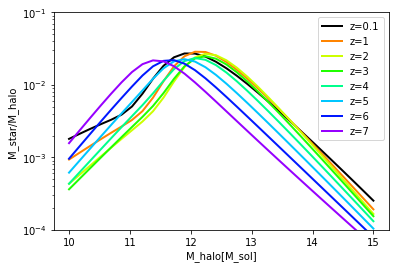

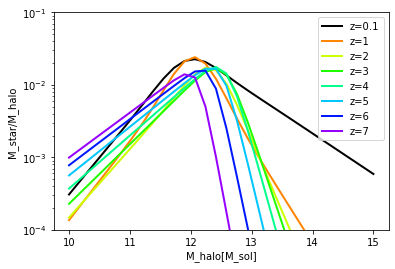

In [117]:
# the following are calibrated for z= 0-8 but we're going to extrapolate to larger z
# from Behroozi and Wechsler, eq 3 w/ parameters on page 10, sec 5
# https://arxiv.org/pdf/1207.6105.pdf
#seems valid for 10^10-10^15 M_sol

def a(z):
    return 1/(1+z)

def nu(z):
    return np.exp(-4*(a(z))**2)

def alpha(z):
    return -1.412 + .731*(a(z)-1)*nu(z)

def delta(z):
    return 3.508 + (2.608*(a(z)-1) - .043*z)*nu(z)

def gamma(z):
    return .316 + (1.319*(a(z)-1) + .279*z)*nu(z)

def log10_m_1(z):
    return  11.514 - (1.793*(a(z)-1) + .251*z)*nu(z) 

def log10_epsilon(z):
    return  -1.777 - .119*(a(z)-1) - .006*(a(z)-1)*nu(z) 

def f(x,z):
    a = -np.log10(np.power(10,(alpha(z)*x)) + 1)
    b = delta(z)*np.power((np.log10(1+np.exp(x))),gamma(z))
    b = b/(1+np.exp(np.power(10, -x)))
    return a+b

def calc_mass(m_h,z):
    m_h = np.array(m_h)
    z   = np.array(z)
    a = log10_epsilon(z) + log10_m_1(z)
    b = f(np.log10(m_h) - log10_m_1(z),z)
    c = -f(0,z)
    log10_m_s = a+b+c
    return np.power(10, log10_m_s)

#J1 from https://arxiv.org/pdf/1806.07893.pdf. I'm not sure if it's safe to say M_peak = M_halo
#fitting parameters pulled from table J1, row: True All All Incl.
#valid for M_halo 10^10 - 10^15 M_sol and z 0-10

E0 = -1.466
Ea = 1.852
Elna = 1.439
Ez =-0.227
M0 = 12.013
Ma = 4.597
Mlna = 4.470
Mz = -0.737
A0 = 1.965
Aa = -2.137
Alna = -1.607
Az = 0.161
B0 = 0.564
Ba = 0.835
Bz = -0.478
D0 = 0.411
Y0 = -0.937
Ya = -2.810
Yz = -0.983
Msol = 1.989e30
def a2(z):
    return 1/(1+z)

def log10_m_2(z):
    return M0 + Ma*(a(z)-1) - Mlna*math.log(a(z)) + Mz*z #+math.log10(Msol)

def epsilon2(z):
    return E0 + Ea*(a(z)-1) - Elna*math.log(a(z)) + Ez*z

def alpha2(z):
    return A0 + Aa*(a(z)-1) - Alna*math.log(a(z)) + Az*z

def beta2(z):
    return B0 + Ba*(a(z)-1) + Bz*z

def delta2(z):
    return D0

def gamma2(z):
    return 10**(Y0 + Ya*(a(z)-1) + Yz*z) 


#currently decreasing as a func of m_halo, from 10^40 to 10^45... This probably isn't correct?

def calc_mass2(m_h, z):
    m_h = np.array(m_h)
    z   = np.array(z)
    x = np.log10(m_h) - log10_m_2(z)
    a = -np.log10(np.power(10, -alpha2(z)*x) + np.power(10,-beta2(z)*x))
    b = gamma2(z)*np.exp(-0.5*np.power(x,2)/(delta2(z)**2))
    log10_m_s = epsilon2(z) + log10_m_2(z) + a + b
    return np.power(10, log10_m_s)
    
plt.figure()
plt.yscale("log")
plt.ylim(0.0001,0.1)
plt.ylabel("M_star/M_halo")
plt.xlabel("M_halo[M_sol]")

x_vals = np.linspace(10,15,30)
plt.plot(x_vals, calc_mass([np.power(10,x_vals)],0.1)[0]/10**x_vals, c="black", label="z=0.1", lw= 2)
for z in range(1,8):
    plt.plot(x_vals, calc_mass([np.power(10,x_vals)],z)[0]/10**x_vals, c=cmap(z/8), label="z="+str(z), lw = 2)
plt.legend()
plt.savefig("old_star_mass_function.pdf")

plt.figure()
plt.yscale("log")
plt.ylim(0.0001,0.1)
plt.ylabel("M_star/M_halo")
plt.xlabel("M_halo[M_sol]")

x_vals = np.linspace(10,15,30)
plt.plot(x_vals, calc_mass2([np.power(10,x_vals)],0.1)[0]/10**x_vals, c="black", label="z=0.1", lw= 2)
for z in range(1,8):
    plt.plot(x_vals, calc_mass2([np.power(10,x_vals)],z)[0]/10**x_vals, c=cmap(z/8), label="z="+str(z), lw= 2)
plt.legend()
plt.savefig("new_star_mass_function.pdf")    

In [118]:
mm_stellar_mass = calc_mass(mm_mass,mm_z)
lw_stellar_mass = calc_mass(lw_mass,lw_z)

<ipython-input-117-6b2cfb4e5b4f>:30: RuntimeWarning: overflow encountered in exp
  b = b/(1+np.exp(np.power(10, -x)))


# BH growth

In [119]:
def evolve_BH(stellar_mass, time, folding_time, fraction_cap, seed):
    #This assumes black holes start right away, fix later
    
    dt = np.array(time[1:len(time)])-np.array(time[0:len(time)-1])
    scale_factor = np.exp(dt/folding_time)
    cap =fraction_cap*np.array(stellar_mass)
    
    if(seed <= cap[0]): bh_mass = [seed]
    else: bh_mass = [cap[0]]
 
    for i,sf in enumerate(scale_factor):
        old_mass = bh_mass[i]
        growth = old_mass*sf
        c = cap[i+1]

        if(growth <= c): 
            bh_mass.append(growth)
        elif(c>old_mass):
            bh_mass.append(c)
        else: 
            bh_mass.append(old_mass) #this occurs when the cap shrinks due to splitting
            
    return bh_mass

In [124]:
mm_bh_mass = evolve_BH(mm_stellar_mass,mm_time, 20, 0.2, 10**5)
lw_bh_mass = evolve_BH(lw_stellar_mass,lw_time, 20, 0.2, 10**5)

In [122]:
# print(list(mm_mass))
# print(list(mm_time))
# print(list(mm_z))
# print(list(mm_stellar_mass))
# print(list(mm_bh_mass))
# print(list(lw_mass))
# print(list(lw_time))
# print(list(lw_z))
# print(list(lw_stellar_mass))
# print(list(lw_bh_mass))

In [1]:
mm_mass = [541340.0, 861230.0, 1230300.0, 1722500.0, 2780500.0, 3863200.0, 4945900.0, 5930200.0, 6766800.0, 7628000.0, 8636900.0, 9645800.0, 11221000.0, 13115000.0, 15871000.0, 20350000.0, 64814000.0, 76280000.0, 86935000.0, 91979000.0, 99287000.0, 104630000.0, 110340000.0, 117500000.0, 123840000.0, 127900000.0, 135780000.0, 144150000.0, 149210000.0, 155050000.0, 157730000.0, 165530000.0, 180100000.0, 188410000.0, 200100000.0, 204190000.0, 209480000.0, 203320000.0, 207190000.0, 213760000.0, 220500000.0, 241090000.0, 256550000.0, 266390000.0, 268240000.0, 267990000.0, 214000000.0, 249190000.0, 235160000.0, 193785000.0, 152410000.0, 174383300.0, 196356700.0, 218330000.0, 112430000.0, 105220000.0, 85803000.0, 49976000.0, 95695000.0, 48376000.0, 37254000.0, 36516000.0, 37673000.0, 34203000.0, 29060000.0, 25000000.0, 32013000.0, 25172000.0, 26280000.0, 25222000.0, 24090000.0, 23893000.0, 22638000.0, 22687000.0, 22761000.0, 23499000.0, 24434000.0, 75017000000.0, 78981000000.0, 82722000000.0, 86786000000.0, 91149000000.0, 94826000000.0, 95746000000.0, 98578000000.0, 101790000000.0, 104830000000.0, 107940000000.0, 111260000000.0, 115500000000.0, 119740000000.0, 124860000000.0, 130700000000.0, 136770000000.0, 142220000000.0, 146830000000.0, 150580000000.0, 154870000000.0, 158590000000.0, 158850000000.0, 159660000000.0, 162670000000.0, 166150000000.0, 169670000000.0, 173770000000.0, 177870000000.0, 181760000000.0, 185090000000.0, 187990000000.0, 190840000000.0, 194270000000.0, 198680000000.0, 202340000000.0, 205390000000.0, 210680000000.0, 214630000000.0, 218230000000.0, 221750000000.0, 225400000000.0, 229160000000.0, 233470000000.0, 238100000000.0, 242730000000.0, 247050000000.0, 251060000000.0, 255260000000.0, 259650000000.0, 263360000000.0, 266940000000.0, 270080000000.0, 273260000000.0, 276010000000.0, 278710000000.0, 281150000000.0, 281300000000.0]
mm_time = [148.80977113935595, 154.7551727054681, 160.72201956215898, 166.65109675362595, 172.5943108799562, 178.54894246446844, 184.5122021682753, 190.48157505618892, 196.39500338039446, 202.36837991895348, 208.3403648449592, 214.30883562420365, 220.2712537730801, 226.22575189432766, 232.17001964749542, 238.10197227901142, 280.05543679809546, 286.02944310257766, 291.9775431082694, 297.96610472470053, 303.9262665840368, 309.85632228190417, 315.8243982111146, 321.76018161069726, 327.7325809752766, 333.67043120769114, 339.64378985547125, 345.6521579461339, 351.5512250162766, 357.55589853307134, 363.52134277754334, 369.44601702107155, 375.40258624228807, 381.39059462538245, 387.33564336967595, 393.31111790385705, 399.2414747082485, 405.20146303020897, 411.1905984620302, 417.1325350259792, 423.10261199133095, 429.02366864889694, 435.049516788962, 441.0254073828885, 446.95011315239316, 452.9010145006453, 458.8779920805803, 464.8017652032442, 470.83000334824135, 476.72442984295975, 482.7233354613676, 488.66651643103893, 494.63371685954303, 500.62486072210714, 506.5586067367931, 512.5153437954932, 518.495086310081, 524.4152394711796, 530.3577134726073, 536.322400449312, 542.3092123992606, 548.2341713832893, 554.2643329915876, 560.2323232189473, 566.136705062038, 572.1463823317815, 578.0919050208049, 584.0576475484295, 589.9581489305449, 595.9639762444675, 601.9038023596937, 607.8629510396826, 613.8414592208092, 619.8393789473006, 625.7691399692071, 631.7174353244855, 637.6843771066199, 643.6698263526378, 649.5853539920877, 655.5184520391944, 661.5585171238068, 667.4383354334415, 673.4246896770616, 674.4988364033456, 679.4288325054705, 685.3603857860621, 691.3089028155567, 697.2745011723143, 703.2565912165634, 709.1647640575196, 715.180493121015, 721.1213927312047, 727.0783078438917, 733.0514345526893, 739.0406658610827, 744.9532606523765, 750.8815239103208, 756.9180999090371, 762.3180774952274, 762.8774428468646, 763.9030440758625, 768.7585662682837, 774.7480804829333, 780.7529689035938, 786.6790949264661, 792.6195820030656, 798.5750623706236, 804.5448707917071, 810.529493905902, 816.5285979023511, 822.4465344667366, 828.3785999661814, 834.4204798368762, 840.2843857648612, 846.258174745029, 852.2458921897727, 858.2472341793768, 864.1653177742492, 870.0966858187079, 876.138949819281, 881.999399078103, 887.9705461173519, 893.9547576458299, 899.952308808675, 905.8641336600356, 911.8876427071534, 917.8249032507888, 923.7748265179816, 929.7373549573446, 935.7122360592097, 941.699794799572, 947.5995746597405, 953.611897131277, 959.5358682561799, 959.9378570568429]
mm_z = [23.277739, 22.651846, 22.06273, 21.512383, 20.992523, 20.500753, 20.034918, 19.59308, 19.177563, 18.77848, 18.398642, 18.03674, 17.69159, 17.3621, 17.047283, 16.74623, 14.926104, 14.703518, 14.489467, 14.281174, 14.080681, 13.887598, 13.699397, 13.5180025, 13.34103, 13.170327, 13.003641, 12.84083, 12.685508, 12.5318, 12.383297, 12.239772, 12.099293, 11.961762, 11.828736, 11.698413, 11.57229, 11.448649, 11.327416, 11.210012, 11.094823, 10.983224, 10.872254, 10.764706, 10.660448, 10.558022, 10.457378, 10.359763, 10.262529, 10.16944, 10.076651, 9.986596, 9.897995, 9.810811, 9.726161, 9.642826, 9.560777, 9.481082, 9.40258, 9.325245, 9.249052, 9.175011, 9.10101, 9.029084, 8.9591675, 8.88924, 8.821253, 8.754194, 8.688983, 8.623713, 8.560229, 8.497578, 8.435742, 8.374707, 8.315324, 8.256688, 8.198786, 8.141603, 8.085953, 8.030976, 7.975855, 7.9229946, 7.8699665, 7.8605347, 7.817564, 7.766547, 7.716116, 7.6662617, 7.616976, 7.56898, 7.52079, 7.473858, 7.4274397, 7.381527, 7.336112, 7.291874, 7.248103, 7.2041187, 7.165265, 7.1612663, 7.153947, 7.119519, 7.077544, 7.036001, 6.995522, 6.9554496, 6.915776, 6.876497, 6.837605, 6.7990947, 6.7615647, 6.7243934, 6.686986, 6.651109, 6.6149864, 6.579202, 6.5437536, 6.509199, 6.474959, 6.4404764, 6.4074073, 6.3740873, 6.3410664, 6.3083386, 6.2764316, 6.2442765, 6.2129254, 6.181844, 6.1510296, 6.120478, 6.0901875, 6.0606513, 6.030865, 6.0018206, 5.9998603]
mm_stellar_mass = [323.6756460016639, 581.2890036725277, 851.7877166729404, 1226.1951321882, 2427.6988683363784, 3568.5958012870233, 4490.33525795417, 4999.13826242906, 5100.708330465163, 5127.400191938851, 5266.918340711722, 5317.3497826833855, 5910.353144870894, 6700.7991581531605, 8246.689513000685, 11554.331717090396, 43365.034674059505, 53317.68200195522, 61627.46167664382, 61231.701032497374, 63744.42658344072, 63413.94120779275, 63378.40506988587, 64913.89557211357, 65259.12071704192, 63143.38079543119, 64859.35508943214, 66790.17042689511, 65555.60065263447, 64940.58714243483, 61756.61178748961, 62837.451191396794, 69033.4078574673, 70046.25254035169, 73530.18507852055, 71182.04605598435, 69855.25465302348, 61230.16495511636, 59449.07224370926, 59351.557772711465, 59316.23758884053, 66994.41443821366, 71578.75889445102, 72853.16821094527, 69738.350130016, 65763.88595988665, 39143.743121646556, 50756.942277635186, 42714.80155967036, 27270.088072233902, 15828.245627321892, 19888.117642450758, 24198.69459300433, 28712.31108927191, 7028.836440238597, 5871.935678056764, 3702.150317061083, 1173.1268669301662, 4264.957524143516, 1013.5846029373703, 571.2725010098031, 528.3698202176295, 542.7646283401795, 429.82372596754783, 297.6340902271835, 211.50596982571724, 339.0610346798472, 200.924252859837, 212.61887655773577, 189.51797478900176, 167.45292933062282, 159.8737864208488, 139.1351372224545, 135.8267665195257, 133.01436888943704, 138.14580043994604, 145.62680176409953, 1343475515.8200357, 1431773807.8124774, 1513370783.6364832, 1603432774.644816, 1702439383.9984117, 1781028399.9560769, 1802541765.9880307, 1861344835.4419532, 1926198448.1766827, 1985718637.999693, 2046835242.8838723, 2113562227.7173014, 2206675677.1006594, 2298956244.132532, 2416462121.942501, 2554097737.068291, 2697774177.4775696, 2823294516.8059664, 2924993822.9491735, 3001944610.3023505, 3093415633.9120398, 3171686815.0558877, 3176229099.765321, 3194001701.546154, 3254662210.648565, 3322658737.083402, 3391466722.240401, 3476927061.747609, 3562094174.776964, 3641005476.459232, 3703705615.451164, 3753847428.897738, 3802221253.061751, 3867355292.0191083, 3960202997.2466288, 4030824862.7238216, 4084806069.01763, 4202071566.273376, 4280756819.252036, 4349170047.446131, 4415595322.2211895, 4485499118.30772, 4557741764.392745, 4646713993.212022, 4744095202.216687, 4841277917.67693, 4929350523.07651, 5008905573.079752, 5093133772.69955, 5183254039.976692, 5253592283.341305, 5319978637.09228, 5373441228.635342, 5427833023.029347, 5470170385.783222, 5510172240.66906, 5543012131.11821, 5544780869.12938]
#mm_bh_mass = [64.73512920033278, 116.25780073450554, 170.3575433345881, 245.23902643764, 444.3243286425282, 713.7191602574047, 898.067051590834, 999.827652485812, 1020.1416660930327, 1025.4800383877703, 1053.3836681423443, 1063.469956536677, 1182.0706289741788, 1340.1598316306322, 1649.337902600137, 2310.8663434180794, 8673.006934811901, 10663.536400391044, 12325.492335328765, 12325.492335328765, 12748.885316688145, 12748.885316688145, 12748.885316688145, 12982.779114422716, 13051.824143408385, 13051.824143408385, 13051.824143408385, 13358.034085379024, 13358.034085379024, 13358.034085379024, 13358.034085379024, 13358.034085379024, 13806.681571493462, 14009.25050807034, 14706.03701570411, 14706.03701570411, 14706.03701570411, 14706.03701570411, 14706.03701570411, 14706.03701570411, 14706.03701570411, 14706.03701570411, 14706.03701570411, 14706.03701570411, 14706.03701570411, 14706.03701570411, 14706.03701570411, 14706.03701570411, 14706.03701570411, 14706.03701570411, 14706.03701570411, 14706.03701570411, 14706.03701570411, 14706.03701570411, 14706.03701570411, 14706.03701570411, 14706.03701570411, 14706.03701570411, 14706.03701570411, 14706.03701570411, 14706.03701570411, 14706.03701570411, 14706.03701570411, 14706.03701570411, 14706.03701570411, 14706.03701570411, 14706.03701570411, 14706.03701570411, 14706.03701570411, 14706.03701570411, 14706.03701570411, 14706.03701570411, 14706.03701570411, 14706.03701570411, 14706.03701570411, 14706.03701570411, 14706.03701570411, 26757.184465219052, 48344.66039835008, 87502.34421874397, 160079.7442342771, 288199.7809494491, 524418.1424421876, 583884.9853223179, 955948.1074840032, 1729969.329570715, 3136022.830921998, 5694582.124812761, 10357638.044244358, 18700336.28635609, 34127872.07303548, 61818605.20760914, 112156574.94132707, 203814151.47774905, 370973891.67324567, 584998764.5898347, 600388922.0604701, 618683126.782408, 634337363.0111775, 635245819.9530642, 638800340.3092308, 650932442.129713, 664531747.4166805, 678293344.4480802, 695385412.3495219, 712418834.9553928, 728201095.2918464, 740741123.0902328, 750769485.7795477, 760444250.6123502, 773471058.4038217, 792040599.4493258, 806164972.5447644, 816961213.803526, 840414313.2546753, 856151363.8504072, 869834009.4892262, 883119064.444238, 897099823.6615441, 911548352.8785491, 929342798.6424044, 948819040.4433374, 968255583.5353861, 985870104.6153021, 1001781114.6159505, 1018626754.53991, 1036650807.9953384, 1050718456.668261, 1063995727.4184561, 1074688245.7270684, 1085566604.6058695, 1094034077.1566446, 1102034448.133812, 1108602426.223642, 1108956173.825876]
lw_mass = [1131900.0, 2214600.0, 2755900.0, 3297300.0, 3444900.0, 4306100.0, 4798300.0, 5659500.0, 7037500.0, 9621200.0, 13509000.0, 15478000.0, 25591000.0, 29922000.0, 20522000.0, 23942000.0, 19513000.0, 16806000.0, 10039000.0, 10581000.0, 9202800.0, 18381000.0, 10975000.0, 13238000.0, 17864000.0, 251720000.0, 256970000.0, 259600000.0, 261590000.0, 262380000.0, 264990000.0, 276450000.0, 291220000.0, 306470000.0, 318580000.0, 322840000.0, 338340000.0, 343700000.0, 354700000.0, 549780000.0, 369910000.0, 390210000.0, 405490000.0, 411220000.0, 449190000.0, 458790000.0, 454730000.0, 468530000.0, 580150000.0, 470800000.0, 479850000.0, 433740000.0, 377960000.0, 431450000.0, 362530000.0, 346020000.0, 313460000.0, 377220000.0, 479313300.0, 581406700.0, 683500000.0, 894890000.0, 1110300000.0, 1184067000.0, 1257833000.0, 1331600000.0, 663540000.0, 748700000.0, 846540000.0, 647230000.0, 554630000.0, 428550000.0, 81257000000.0, 81876000000.0, 82253000000.0, 82969000000.0, 84271000000.0, 85603000000.0, 87617000000.0, 88156000000.0, 90867000000.0, 94602000000.0, 97834000000.0, 100850000000.0, 103940000000.0, 107830000000.0, 110930000000.0, 114320000000.0, 117170000000.0, 119930000000.0, 122610000000.0, 125540000000.0, 129070000000.0, 132740000000.0, 137540000000.0, 137860000000.0, 139210000000.0, 146200000000.0, 153720000000.0, 160420000000.0, 166230000000.0, 170750000000.0, 179570000000.0, 187040000000.0, 195460000000.0, 203910000000.0, 212980000000.0, 220930000000.0, 227430000000.0, 233470000000.0, 238680000000.0, 244040000000.0, 250030000000.0, 255910000000.0, 263230000000.0, 272610000000.0, 280990000000.0, 287110000000.0, 293210000000.0, 299550000000.0, 304390000000.0, 309730000000.0, 314190000000.0, 318610000000.0, 322940000000.0, 326860000000.0, 331130000000.0, 335680000000.0, 340240000000.0, 345590000000.0, 345590000000.0]
lw_time = [172.5943108799562, 178.54894246446844, 184.5122021682753, 190.48157505618892, 196.39500338039446, 202.36837991895348, 208.3403648449592, 214.30883562420365, 220.2712537730801, 226.22575189432766, 232.17001964749542, 238.10197227901142, 280.05543679809546, 286.02944310257766, 291.9775431082694, 297.96610472470053, 303.9262665840368, 309.85632228190417, 315.8243982111146, 321.76018161069726, 327.7325809752766, 333.67043120769114, 339.64378985547125, 345.6521579461339, 351.5512250162766, 357.55589853307134, 363.52134277754334, 369.44601702107155, 375.40258624228807, 381.39059462538245, 387.33564336967595, 393.31111790385705, 399.2414747082485, 405.20146303020897, 411.1905984620302, 417.1325350259792, 423.10261199133095, 429.02366864889694, 435.049516788962, 441.0254073828885, 446.95011315239316, 452.9010145006453, 458.8779920805803, 464.8017652032442, 470.83000334824135, 476.72442984295975, 482.7233354613676, 488.66651643103893, 494.63371685954303, 500.62486072210714, 506.5586067367931, 512.5153437954932, 518.495086310081, 524.4152394711796, 530.3577134726073, 536.322400449312, 542.3092123992606, 548.2341713832893, 554.2643329915876, 560.2323232189473, 566.136705062038, 572.1463823317815, 578.0919050208049, 584.0576475484295, 589.9581489305449, 595.9639762444675, 601.9038023596937, 607.8629510396826, 613.8414592208092, 619.8393789473006, 625.7691399692071, 631.7174353244855, 637.6843771066199, 643.6698263526378, 649.5853539920877, 655.5184520391944, 661.5585171238068, 667.4383354334415, 673.4246896770616, 674.4988364033456, 679.4288325054705, 685.3603857860621, 691.3089028155567, 697.2745011723143, 703.2565912165634, 709.1647640575196, 715.180493121015, 721.1213927312047, 727.0783078438917, 733.0514345526893, 739.0406658610827, 744.9532606523765, 750.8815239103208, 756.9180999090371, 762.3180774952274, 762.8774428468646, 763.9030440758625, 768.7585662682837, 774.7480804829333, 780.7529689035938, 786.6790949264661, 792.6195820030656, 798.5750623706236, 804.5448707917071, 810.529493905902, 816.5285979023511, 822.4465344667366, 828.3785999661814, 834.4204798368762, 840.2843857648612, 846.258174745029, 852.2458921897727, 858.2472341793768, 864.1653177742492, 870.0966858187079, 876.138949819281, 881.999399078103, 887.9705461173519, 893.9547576458299, 899.952308808675, 905.8641336600356, 911.8876427071534, 917.8249032507888, 923.7748265179816, 929.7373549573446, 935.7122360592097, 941.699794799572, 947.5995746597405, 953.611897131277, 959.5358682561799, 959.9378570568429]
lw_z = [20.992523, 20.500753, 20.034918, 19.59308, 19.177563, 18.77848, 18.398642, 18.03674, 17.69159, 17.3621, 17.047283, 16.74623, 14.926104, 14.703518, 14.489467, 14.281174, 14.080681, 13.887598, 13.699397, 13.5180025, 13.34103, 13.170327, 13.003641, 12.84083, 12.685508, 12.5318, 12.383297, 12.239772, 12.099293, 11.961762, 11.828736, 11.698413, 11.57229, 11.448649, 11.327416, 11.210012, 11.094823, 10.983224, 10.872254, 10.764706, 10.660448, 10.558022, 10.457378, 10.359763, 10.262529, 10.16944, 10.076651, 9.986596, 9.897995, 9.810811, 9.726161, 9.642826, 9.560777, 9.481082, 9.40258, 9.325245, 9.249052, 9.175011, 9.10101, 9.029084, 8.9591675, 8.88924, 8.821253, 8.754194, 8.688983, 8.623713, 8.560229, 8.497578, 8.435742, 8.374707, 8.315324, 8.256688, 8.198786, 8.141603, 8.085953, 8.030976, 7.975855, 7.9229946, 7.8699665, 7.8605347, 7.817564, 7.766547, 7.716116, 7.6662617, 7.616976, 7.56898, 7.52079, 7.473858, 7.4274397, 7.381527, 7.336112, 7.291874, 7.248103, 7.2041187, 7.165265, 7.1612663, 7.153947, 7.119519, 7.077544, 7.036001, 6.995522, 6.9554496, 6.915776, 6.876497, 6.837605, 6.7990947, 6.7615647, 6.7243934, 6.686986, 6.651109, 6.6149864, 6.579202, 6.5437536, 6.509199, 6.474959, 6.4404764, 6.4074073, 6.3740873, 6.3410664, 6.3083386, 6.2764316, 6.2442765, 6.2129254, 6.181844, 6.1510296, 6.120478, 6.0901875, 6.0606513, 6.030865, 6.0018206, 5.9998603]
lw_stellar_mass = [366.58706213292555, 1107.8837995219878, 1314.0180685807684, 1457.126480330609, 1236.0697563878891, 1544.431025887219, 1534.9342274004273, 1738.5296075920417, 2223.2632487561546, 3501.899730771929, 5885.186486660582, 6516.685773533809, 6240.760092298118, 7576.022035113273, 3040.8591096611276, 3708.5912419096135, 2153.0314873103157, 1409.3810207130336, 432.3864998597814, 434.43558999101924, 293.5904903966145, 1121.1828236688882, 349.11141117369374, 469.6864461504707, 801.0318226859127, 177400.93209877447, 169863.16612867606, 159653.46024679116, 149565.38825786125, 139048.70891355106, 131496.4709522962, 133220.2891646545, 138056.21995535615, 142990.56022887086, 144605.36932959626, 139066.83161563208, 143554.68486806267, 139253.08417612474, 139623.5732013663, 324455.2575927744, 135238.50827656657, 142601.2815424058, 145944.9015501052, 142311.7595760592, 161740.36657362888, 160475.2601752285, 149731.0985129356, 151549.0211322818, 223930.76065548052, 139059.0861394061, 138102.36861266586, 107300.47689437868, 77415.0648830018, 97299.33519972631, 65315.22563950649, 56979.001738202256, 44705.04212335688, 62802.82001689272, 98588.0546491406, 140863.54317472063, 188950.65372406927, 315764.85204922827, 473123.79889359605, 520638.71227669815, 568954.8490008315, 617386.7440204393, 144341.81164630974, 178722.49516779513, 222299.634425714, 124703.98746985623, 88355.53781901594, 50754.790217174996, 1546319582.378096, 1539268517.2775345, 1525203967.0189836, 1520424066.250143, 1531599390.1427934, 1544000658.3883743, 1575041351.6077585, 1585633445.4736223, 1640869868.0913215, 1720549321.42502, 1785486227.1805606, 1843849315.8231587, 1903924474.0016766, 1986931698.6980076, 2046503869.735047, 2114437262.4725678, 2166512908.390676, 2215619931.413708, 2262045766.4377728, 2315732078.5316477, 2386265215.5041056, 2459976065.887983, 2569265401.73193, 2575484157.0889726, 2608815763.003672, 2783761215.5251517, 2967601186.4557257, 3127455683.6732774, 3261898093.4943843, 3359077025.5280867, 3578701455.6360927, 3759108759.3151035, 3965726751.111206, 4172300318.470077, 4395746915.247837, 4587041177.819349, 4737138492.627613, 4875156832.256273, 4989593680.26722, 5107972181.798896, 5243492692.569331, 5376254129.5557, 5548239274.965801, 5775405275.755802, 5975551951.036458, 6113896048.92109, 6251571064.092294, 6395579006.517654, 6499592113.465711, 6616527350.753342, 6710114758.60335, 6802498258.307178, 6892320887.873622, 6970888076.744595, 7058793000.461665, 7154664046.616218, 7250229690.735848, 7367748226.134966, 7365813711.516601]
#lw_bh_mass = [73.31741242658511, 132.98831793532844, 241.43185507507604, 291.4252960661218, 291.4252960661218, 308.8862051774438, 308.8862051774438, 347.70592151840833, 444.6526497512309, 700.3799461543858, 1177.0372973321164, 1303.3371547067618, 1303.3371547067618, 1515.2044070226548, 1515.2044070226548, 1515.2044070226548, 1515.2044070226548, 1515.2044070226548, 1515.2044070226548, 1515.2044070226548, 1515.2044070226548, 1515.2044070226548, 1515.2044070226548, 1515.2044070226548, 1515.2044070226548, 2762.173041073674, 5015.645505640569, 9070.519620125722, 16455.939478856813, 27809.741782710214, 27809.741782710214, 27809.741782710214, 27809.741782710214, 28598.112045774174, 28921.073865919254, 28921.073865919254, 28921.073865919254, 28921.073865919254, 28921.073865919254, 52570.73458969663, 52570.73458969663, 52570.73458969663, 52570.73458969663, 52570.73458969663, 52570.73458969663, 52570.73458969663, 52570.73458969663, 52570.73458969663, 52570.73458969663, 52570.73458969663, 52570.73458969663, 52570.73458969663, 52570.73458969663, 52570.73458969663, 52570.73458969663, 52570.73458969663, 52570.73458969663, 52570.73458969663, 52570.73458969663, 52570.73458969663, 52570.73458969663, 63152.97040984566, 94624.75977871922, 104127.74245533964, 113790.9698001663, 123477.34880408787, 123477.34880408787, 123477.34880408787, 123477.34880408787, 123477.34880408787, 123477.34880408787, 123477.34880408787, 224247.84856200797, 408012.100302392, 737192.9005900064, 1334296.4127066764, 2441006.9282811745, 4394670.077665489, 7996691.431142483, 8903483.081564948, 14576959.531061476, 26379771.778095037, 47820250.42672076, 86834936.46760608, 157940446.16680124, 285155693.21111375, 409300773.94700944, 422887452.4945136, 433302581.6781352, 443123986.28274167, 452409153.28755456, 463146415.7063296, 477253043.10082114, 491995213.17759657, 513853080.34638596, 515096831.4177945, 521763152.6007345, 556752243.1050304, 593520237.2911452, 625491136.7346555, 652379618.6988769, 671815405.1056174, 715740291.1272186, 751821751.8630208, 793145350.2222413, 834460063.6940155, 879149383.0495675, 917408235.56387, 947427698.5255227, 975031366.4512547, 997918736.0534439, 1021594436.3597792, 1048698538.5138663, 1075250825.9111402, 1109647854.9931602, 1155081055.1511605, 1195110390.2072916, 1222779209.784218, 1250314212.8184588, 1279115801.303531, 1299918422.6931422, 1323305470.1506684, 1342022951.72067, 1360499651.6614356, 1378464177.5747244, 1394177615.348919, 1411758600.092333, 1430932809.3232436, 1450045938.1471698, 1473549645.2269933, 1473549645.2269933]

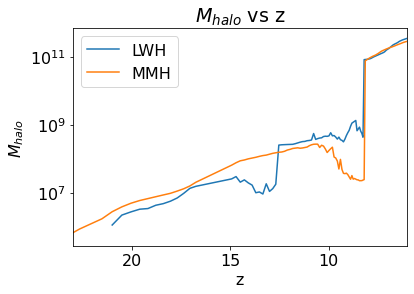

In [4]:
plt.rcParams.update({'font.size': 16})

plt.figure()
plt.xlim(23, 6)
plt.yscale("log")
plt.title(r"$M_{halo}$ vs z")
plt.xlabel("z")
plt.ylabel(r"$M_{halo}$")
plt.plot(lw_z, lw_mass, label = "LWH")
plt.plot(mm_z, mm_mass, label = "MMH")
plt.legend()
plt.savefig("halo_mass_vs_z_full.pdf")

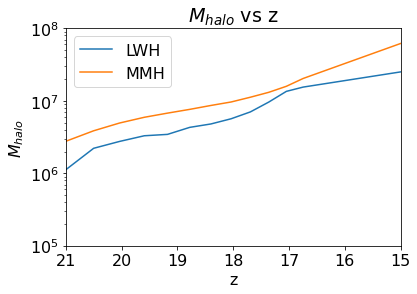

In [8]:
plt.figure()
plt.xlim(21, 15)
plt.yscale("log")
plt.ylim(1e5,1e8)
plt.title(r"$M_{halo}$ vs z")
plt.xlabel("z")
plt.ylabel(r"$M_{halo}$")
plt.plot(lw_z, lw_mass, label = "LWH")
plt.plot(mm_z, mm_mass, label = "MMH")
plt.legend()
plt.savefig("halo_mass_vs_z_paper_comparison.pdf")

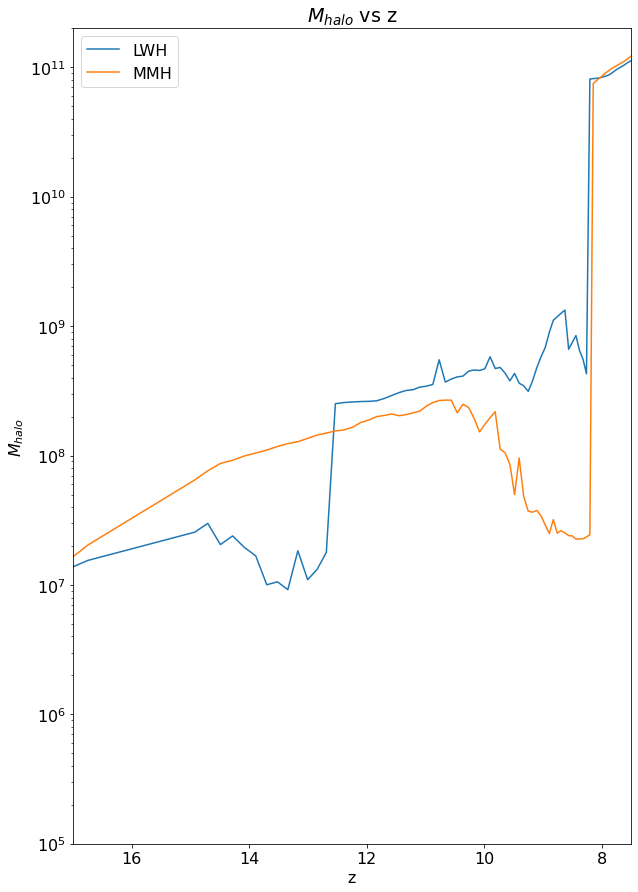

In [11]:
plt.figure(figsize=(10,15))
plt.xlim(17, 7.5)
plt.yscale("log")
plt.ylim(1e5,2e11)
plt.title(r"$M_{halo}$ vs z")
plt.xlabel("z")
plt.ylabel(r"$M_{halo}$")
plt.plot(lw_z, lw_mass, label = "LWH")
plt.plot(mm_z, mm_mass, label = "MMH")
plt.legend()
plt.savefig("halo_mass_vs_z_raymond_comparison.pdf")

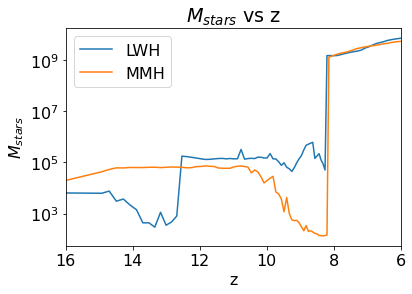

In [154]:
plt.figure()
plt.xlim(16, 6)
plt.yscale("log")
plt.title(r"$M_{stars}$ vs z")
plt.xlabel("z")
plt.ylabel(r"$M_{stars}$")
plt.plot(lw_z, lw_stellar_mass, label = "LWH")
plt.plot(mm_z, mm_stellar_mass, label = "MMH")
plt.legend()
plt.savefig("stellar_mass_vs_z.pdf")

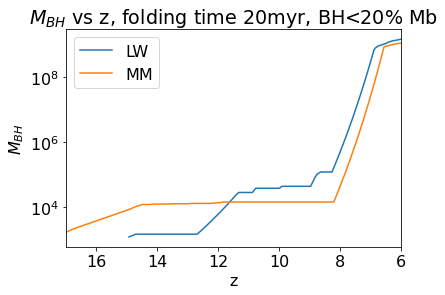

In [165]:
mm_seed_mass = 30000
lw_seed_mass = 200000
mm_seed_z = 17.5
lw_seed_z = 15.3

mm_bh_indices = np.where(np.array(mm_z) < mm_seed_z)
lw_bh_indices = np.where(np.array(lw_z) < lw_seed_z)


mm_bh_mass = evolve_BH(np.array(mm_stellar_mass)[mm_bh_indices],np.array(mm_time)[mm_bh_indices], 20, 0.2, mm_seed_mass)
lw_bh_mass = evolve_BH(np.array(lw_stellar_mass)[lw_bh_indices],np.array(lw_time)[lw_bh_indices], 20, 0.2, lw_seed_mass)

plt.figure()
plt.xlim(17, 6)
plt.yscale("log")
plt.title(r"$M_{BH}$ vs z, folding time 20myr, BH<20% Mb")
plt.xlabel("z")
plt.ylabel(r"$M_{BH}$")
plt.plot(np.array(lw_z)[lw_bh_indices], lw_bh_mass, label = "LW")
plt.plot(np.array(mm_z)[mm_bh_indices], mm_bh_mass, label = "MM")
plt.legend()
plt.savefig("mbh_vs_z.pdf")

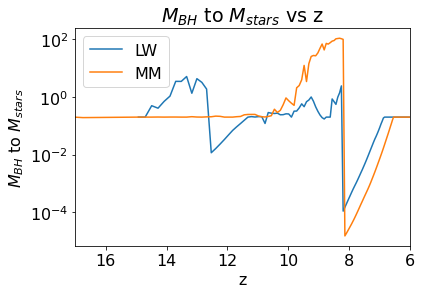

In [163]:
mm_ratio = mm_bh_mass/np.array(mm_stellar_mass)[mm_bh_indices]
lw_ratio = lw_bh_mass/np.array(lw_stellar_mass)[lw_bh_indices]
plt.figure()
plt.xlim(17, 6)
plt.yscale("log")
plt.title(r"$M_{BH}$ to $M_{stars}$ vs z")
plt.xlabel("z")
plt.ylabel(r"$M_{BH}$ to $M_{stars}$")
plt.plot(np.array(lw_z)[lw_bh_indices], lw_ratio, label = "LW")
plt.plot(np.array(mm_z)[mm_bh_indices], mm_ratio, label = "MM")
plt.legend()
plt.savefig("mbh_to_mstar_vs_z.pdf")

# Raymonds old data

In [2]:
LW=[   [16.455053237912374, 16.179178835251676, 15.909029421711196, 15.65278934221482, 15.406890894175554, 15.155088852988694, 15.0, 14.926102882624622, 14.703517587939698, 14.489467162329614, 14.28117359413203, 14.080681646810437, 13.887598630340927, 13.699397324709688, 13.518002322880372, 13.34102968593145, 13.17032733456143, 13.003640946646128, 12.84083044982699, 12.685507048036131, 12.531799729364007, 12.383297644539615, 12.239772275916854, 12.099292638197536, 11.961762799740765, 11.828736369467606, 11.698412698412698, 11.572290671360323, 11.448649321548611, 11.32741617357002, 11.21001221001221, 11.094823415578132, 10.983223487118035, 10.872254541137362, 10.76470588235294, 10.66044776119403, 10.55802126675913, 10.457378551787352, 10.359763716914689, 10.262529564140106, 10.169440411035408, 10.076650420912715, 9.986596352450011, 9.897994768962512, 9.81081081081081, 9.726161106939827, 9.642826734780758, 9.560777273207309, 9.481081647626036, 9.402579839800271, 9.325245224574083, 9.24905196269345, 9.175010175010174, 9.1010101010101, 9.029084344599339, 8.959167413604224, 8.889240506329113, 8.821253191907289, 8.754194303550527, 8.688983625617674, 8.6237128284092, 8.560229445506693, 8.497578117580018, 8.435742592942065, 8.374707040404987, 8.315323707498836, 8.256687957048968, 8.198785760279643, 8.141603437242892, 8.08595311648192],             [346619.71830985916, 901126.7605633803, 2460563.3802816905, 5719718.309859156, 7278873.23943662, 12374647.887323944, 28211267.605633806, 47211267.60563381, 16042253.521126762, 17225352.112676058, 36943661.97183099, 18929577.464788735, 12878873.23943662, 6828169.014084508, 239859154.9295775, 248169014.08450708, 223661971.83098593, 159014084.50704226, 94422535.21126762, 71436619.71830986, 27521126.76056338, 13309859.154929578, 359014084.5070423, 368873239.43661976, 367183098.59154934, 382957746.47887325, 428591549.2957747, 432816901.4084507, 482676056.3380282, 386760563.38028175, 433380281.6901409, 439436619.7183099, 445492957.7464789, 451549295.77464795, 453943661.971831, 214507042.25352114, 385211267.60563385, 203098591.54929578, 455211267.60563385, 417746478.87323946, 746056338.028169, 1074366197.1830988, 714929577.4647888, 622957746.4788733, 477887323.943662, 863380281.690141, 2740845070.4225354, 3387323943.661972, 4033802816.9014087, 11681690140.845072, 19464788732.394367, 7280281690.140845, 10064788732.394367, 12849295774.647888, 15633802816.90141, 10314084507.042253, 11122535211.267607, 11929577464.788733, 94028169014.08452, 93422535211.26761, 99816901408.45071, 102577464788.7324, 104056338028.16902, 107169014084.50705, 66957746478.873245, 112436619718.30988, 112929577464.78874, 112732394366.19719, 88394366197.1831, 116014084507.04227],         [346619.71830985916, 6690140.845070424, 73591549.29577465, 48211267.60563381, 46816901.40845071, 12374647.887323944, 28211267.605633806, 47211267.60563381, 16042253.521126762, 17225352.112676058, 160985915.49295777, 195492957.7464789, 195070422.5352113, 19422535.21126761, 239859154.9295775, 248169014.08450708, 223661971.83098593, 297183098.59154934, 314929577.46478873, 332816901.4084507, 347605633.8028169, 18647887.323943663, 359014084.5070423, 368873239.43661976, 367183098.59154934, 382957746.47887325, 428591549.2957747, 432816901.4084507, 4932394366.197184, 5935211267.605635, 6545070422.535212, 3690140845.0704226, 2953521126.760564, 8185915492.957747, 1220000000.0, 8738028169.014086, 2209859154.929578, 2192957746.4788733, 2177464788.7323947, 4442253521.1267605, 746056338.028169, 2204225352.112676, 2471830985.915493, 1402112676.056338, 59901408450.70423, 57830985915.492966, 6132394366.197184, 7276056338.02817, 6376056338.02817, 15591549295.774649, 25436619718.30986, 27605633802.816902, 29774647887.323948, 20647887323.943665, 37676056338.028175, 39281690140.84508, 18845070422.535213, 89098591549.29578, 94028169014.08452, 93422535211.26761, 99816901408.45071, 102577464788.7324, 104056338028.16902, 107169014084.50705, 66957746478.873245, 112436619718.30988, 112929577464.78874, 112732394366.19719, 88394366197.1831, 116014084507.04227], [ 0, 0.004203926735805602, 0.0038712659428108325, 0.00752458636736847, 0.006905077841706204, 0, 0, 0, 0, 0, 0.009849192860329007, 0.00511445011706563, 0.003609141172079399, 0.005070601542222878, 0, 0, 0, 0.010083223690860935, 0.010049009901476563, 0.006564426859976727, 0.0050605730900755925, 0.0033314261210496588, 0, 0, 0, 0, 0, 0, 0.03382256051809499, 0.026973991176685343, 0.03528983281343344, 0.030408581025755874, 0.0032562862282057535, 0.0419838647577856, 0.020546208896047465, 0.04579999344977947, 0.022491931886788715, 0.024560482487119225, 0.02523946512904181, 0.02782209553574532, 0, 0.01663614739054601, 0.019924680674983868, 0.02375244197971879, 0.0707445898991597, 0.06840407151624572, 0.02686798280481672, 0.0323710812300113, 0.03320405246351611, 0.03299796508877371, 0.03321037337941296, 0.01924586449084434, 0.024647857919098376, 0.03886461758463408, 0.03595307219139895, 0.010797309850146751, 0.02589969111785076, 0.015895263445437395, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0 ]    ] 
LWz=LW[0]
LWm=LW[1]
LWhm=LW[2]
LWr=LW[3]
MM=[   [16.455053237912374, 16.179178835251676, 15.909029421711196, 15.65278934221482, 15.406890894175554, 15.155088852988694, 15.0, 14.926102882624622, 14.703517587939698, 14.489467162329614, 14.28117359413203, 14.080681646810437, 13.887598630340927, 13.699397324709688, 13.518002322880372, 13.34102968593145, 13.17032733456143, 13.003640946646128, 12.84083044982699, 12.685507048036131, 12.531799729364007, 12.383297644539615, 12.239772275916854, 12.099292638197536, 11.961762799740765, 11.828736369467606, 11.698412698412698, 11.572290671360323, 11.448649321548611, 11.32741617357002, 11.21001221001221, 11.094823415578132, 10.983223487118035, 10.872254541137362, 10.76470588235294, 10.66044776119403, 10.55802126675913, 10.457378551787352, 10.359763716914689, 10.262529564140106, 10.169440411035408, 10.076650420912715, 9.986596352450011, 9.897994768962512, 9.81081081081081, 9.726161106939827, 9.642826734780758, 9.560777273207309, 9.481081647626036, 9.402579839800271, 9.325245224574083, 9.24905196269345, 9.175010175010174, 9.1010101010101, 9.029084344599339, 8.959167413604224, 8.889240506329113, 8.821253191907289, 8.754194303550527, 8.688983625617674, 8.6237128284092, 8.560229445506693, 8.497578117580018, 8.435742592942065, 8.374707040404987, 8.315323707498836, 8.256687957048968, 8.198785760279643, 8.141603437242892, 8.08595311648192],             [7625352.112676057, 8839436.619718311, 7521126.760563381, 8145070.422535212, 7036619.71830986, 18887323.943661973, 80098591.54929578, 85690140.84507044, 96323943.66197184, 106619718.30985917, 120971830.9859155, 118436619.71830986, 148591549.29577467, 139436619.71830988, 165352112.67605636, 173380281.69014087, 183380281.69014087, 184647887.32394367, 200140845.07042256, 209436619.71830988, 218028169.01408452, 217464788.7323944, 96816901.40845071, 250140845.07042256, 259859154.9295775, 125859154.92957747, 117225352.11267607, 170000000.0, 64126760.563380286, 59521126.76056339, 54901408.45070423, 21197183098.591553, 21915492957.74648, 23042253521.126762, 23830985915.492958, 24901408450.704227, 25591549295.77465, 26352112676.05634, 27450704225.352116, 24014084507.042255, 25676056338.02817, 27760563380.281693, 29014084507.042255, 30028169014.08451, 30535211267.605637, 32366197183.098595, 29605633802.816902, 33028169014.08451, 30943661971.83099, 26183098591.549297, 37239436619.718315, 38802816901.408455, 35873239436.61972, 40464788732.39437, 41253521126.76057, 43056338028.16902, 44197183098.59155, 49464788732.39437, 54718309859.15494, 59985915492.95775, 66957746478.873245, 73915492957.74649, 80887323943.66197, 60394366197.183105, 91450704225.35213, 69380281690.14085, 47309859154.92958, 88563380281.69016, 68084507042.253525, 110197183098.59155],          [7625352.112676057, 8839436.619718311, 7521126.760563381, 11646478.873239437, 75323943.66197184, 82661971.83098592, 87422535.21126762, 81070422.53521128, 96323943.66197184, 106619718.30985917, 120971830.9859155, 118436619.71830986, 148591549.29577467, 139436619.71830988, 165352112.67605636, 173380281.69014087, 183380281.69014087, 184647887.32394367, 200140845.07042256, 209436619.71830988, 218028169.01408452, 217464788.7323944, 96816901.40845071, 250140845.07042256, 259859154.9295775, 125859154.92957747, 117225352.11267607, 220422535.21126762, 64126760.563380286, 19647887323.943665, 20225352112.67606, 21197183098.591553, 21915492957.74648, 23042253521.126762, 23830985915.492958, 24901408450.704227, 25591549295.77465, 26352112676.05634, 27450704225.352116, 24014084507.042255, 25676056338.02817, 27760563380.281693, 29014084507.042255, 30028169014.08451, 30535211267.605637, 32366197183.098595, 29605633802.816902, 33028169014.08451, 30943661971.83099, 26183098591.549297, 37239436619.718315, 38802816901.408455, 35873239436.61972, 40464788732.39437, 41253521126.76057, 43056338028.16902, 44197183098.59155, 49464788732.39437, 65605633802.81691, 59985915492.95775, 77816901408.45071, 73915492957.74649, 80887323943.66197, 88352112676.05635, 91450704225.35213, 93563380281.69016, 98436619718.30986, 101704225352.11269, 104957746478.87325, 110197183098.59155], [ 0, 0, 0, 0.004822789649155053, 0.007368459811927571, 0.0074099730093987425, 0.0031429444793061754, 0.005329971857335843, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.009597364221492762, 0, 0.05562099783355257, 0.05977221177102313, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.015726452238187815, 0, 0.0647683178722449, 0, 0, 0.0268183034511894, 0, 0.010622678569929506, 0.03232852919636058, 0.06172105151405045, 0.02866559959254286, 0 ]   ]
MMz=MM[0]
MMm=MM[1]
MMhm=MM[2]
MMr=MM[3]